<a href="https://colab.research.google.com/github/pachterlab/GFCP_2022/blob/main/notebooks/abcd_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Figure __:  Sampling cell observations from 'true' process time

In this notebook, we simulate a system with the bifurcating topology $AB(C/D)$, plot the expression over observed process times, and visualize the corresponding 'pseudotime' assignments for each cell.

# Dependencies


In [1]:
import time
t1 = time.time()

In [2]:
## uncomment this cell if run in colab ##

%%capture
!pip install --upgrade git+https://github.com/meichenfang/velocyto.py.git
!pip install scanpy umap-learn



In [3]:
!git clone https://github.com/pachterlab/GFCP_2022.git

Cloning into 'GFCP_2022'...
remote: Enumerating objects: 962, done.
remote: Counting objects: 100% (962/962), done.
remote: Compressing objects: 100% (785/785), done.
remote: Total 962 (delta 450), reused 482 (delta 161), pack-reused 0
Receiving objects: 100% (962/962), 264.68 MiB | 29.87 MiB/s, done.
Resolving deltas: 100% (450/450), done.


In [4]:
%cd GFCP_2022

/content/GFCP_2022


In [5]:
from vis import * 

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
## run locally ##
# %cd ../../GFCP_2021
# from vis import * 
# %cd notebooks

In [6]:
import warnings
warnings.filterwarnings("ignore")


In [7]:
from os.path import exists

plt.rcParams.update({'font.size': 22})

# Simulations

Generate or load simulation data

In [8]:
!mkdir -p data

In [9]:
nCells,nGenes,T,tau,topo =  2000,100,10,[0,3,7],"ab(c/d)"
topo_ = 'abcd'

meta = nCells,nGenes,T,tau,topo
filename="data/simdata_"+topo_

tsim_ = time.time()

from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(2812)))


szfig = [1,1]
N = np.prod(szfig)
for i_ in range(N):
    simdata = simulate_occup_meas(nCells,nGenes,T,tau,topo,seed=18)
    sim_export(simdata,meta,filename+str(i_))

dtime = time.time()-tsim_
print('Sim runtime: {:.1f} seconds.'.format(dtime))


Sim runtime: 18.3 seconds.


Plot expression over observed time

In [10]:
import seaborn as sns
import matplotlib
%matplotlib inline

In [11]:
def getXtheo(vlm,geneind,meta):
  nCells,nGenes,T,tau,topo = meta
  j=geneind

  tvec = vlm.ca['time']
  gamma = vlm.ra['gamma']
  beta = vlm.ra['beta']
  dict_nk = {"aba":2,"ab(a/c)":3,"ab(c/d)":4}
  dict_Kval = {"aba":[0],"ab(a/c)":[0,2],"ab(c/d)":[2,3]}
  n_K = dict_nk[topo]
  K = np.vstack([vlm.ra['k'+str(i)] for i in range(n_K)]).T

  branches = dict_Kval[topo]
  n_branches = len(branches)

  i=0
  Xtheo = [eval_x(get_cell_spec_K(K[j],branches[i]),tau,t,beta[j],gamma[j]) for t in tvec]
  Xtheo = np.asarray(Xtheo)
  Xtheo[np.isnan(Xtheo)]=0
  Xtheo[np.isinf(Xtheo)]=0

  return Xtheo ,tvec

In [12]:
def addJitter(Xtheo,celltype,ind=1):
  types = np.unique(celltype)
  for i in types:
    if i < 3:
      Xtheo[celltype == i,ind] = Xtheo[celltype == i,ind] + np.random.normal(0,1,Xtheo[celltype == i,ind].shape[0])
    else:
      Xtheo[celltype == i,ind] = Xtheo[celltype == i,ind] + np.random.normal(-1,1,Xtheo[celltype == i,ind].shape[0])

  return Xtheo

In [13]:
#Get X theoretical (not imputed values by velocity)
vlm = vcy.VelocytoLoom(loom_filepath=filename+str(0)+'.loom')
tvec = vlm.ca['time']
tvec

array([6.50374242, 5.05453374, 8.78601471, ..., 6.58106837, 2.92963902,
       9.8477949 ])

In [14]:
geneind = 8

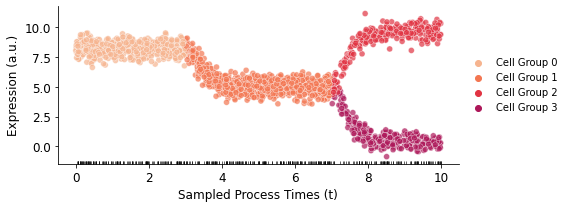

In [15]:
#for i in geneind:

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import random
from matplotlib import cm

X, t = getXtheo(vlm,geneind,meta)
#Add jitter
X[:,1] = X[:,1] + np.random.normal(0,0.5,X.shape[0])
X[vlm.ca['celltype'] == 3,1] = -1*X[vlm.ca['celltype'] == 3,1]


fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(8,3))
names = ['Cell Group '+str(i) for i in vlm.ca['celltype']]
sns.scatterplot(t,X[:,1] + 5,hue=pd.Categorical(names),alpha=0.7,palette=sns.color_palette("rocket")[::-1][0:4])

# ---- Figure aesthetics ---
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),loc='center left',bbox_to_anchor=(1, 0.5),prop={'size': 10},frameon=False,ncol=1)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Sampled Process Times (t)',fontsize=12)
ax.set_ylabel('Expression (a.u.)',fontsize=12)


samp = random.sample(list(t),int(len(t)/5))

ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(samp))

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', size=3, direction='in')

fig.tight_layout()
plt.savefig('observedTimes.pdf')

Make pseudotime image for cells

In [16]:
#Find min time and 'root' cell

m = X[t==np.min(t),1]

#Get euclidean distance of all cells from that cell
dists = (X[:,1]-m)**2
dists.shape

(2000,)

In [17]:
dists = (dists-np.min(dists))/np.max(dists) #0 to 1 like pseudotime

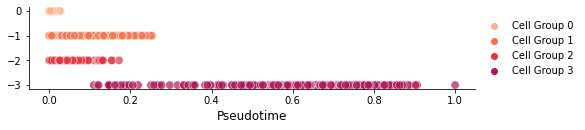

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(8,1.5))
names = ['Cell Group '+str(i) for i in vlm.ca['celltype']]
#ys = [0]*len(names) + np.random.normal(0,0.05,len(names))
sns.scatterplot(dists ,
                vlm.ca['celltype']*-1,hue=pd.Categorical(names),
                alpha=0.7,palette=sns.color_palette("rocket")[::-1][0:4],
                s=70) #np.random.normal(0,0.02,len(names))**2


# ---- Figure aesthetics ---

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),loc='center left',bbox_to_anchor=(1, 0.5),prop={'size': 10},frameon=False,ncol=1)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Pseudotime',fontsize=12)


#fig.tight_layout()
plt.savefig('pseudotime.pdf')